In [60]:
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

class Results:
    def __init__(self, measure, dataset_name, model_name, specific_train_route=None, x=4):
        self.dataset_name = dataset_name
        self.model_name = model_name
        self.specific_train_route = specific_train_route
        self.x = x
        self.measure = measure
        self.relative_path = f'Results/Shifted_Runs/{dataset_name}/{model_name}/*results365.csv'
        # self.relative_path = f'/Users/clarasofiechristiansen/Skrivebord/Shifted_Runs/{dataset_name}/{model_name}/*results365.csv' # LSTM
        if self.measure == 'FI':
            self.relative_path = f'Results/Shifted_Runs/{dataset_name}/{model_name}/*feature_importances365.csv'
        
        self.data = self.data_from_files(self.relative_path, self.measure)
        #if measure == 'Error':
        #    self.data = self.data_from_files_error(self.relative_path, self.measure)
        self.data_route = self.extract_train_routes(specific_train_route, self.data)
    
    def data_from_files(self, relative_path, measure):
        file_list_results = glob.glob(relative_path)
        
        result_df = pd.DataFrame()

        for file in file_list_results:
            index_start = len(relative_path.split('*')[0])
            data_from_file = pd.read_csv(file)
            file_dict = {}
            file_dict['route_station'] = file[index_start:].split('_')[0]
            for i in range(1, self.x + 1):
                if measure == 'Error':
                    file_dict[f'{measure}_baseline{i}'] = data_from_file[f'{measure}_baseline{i}'][0] # data_from_file[f'{measure}_baseline{0}'][0] # for LSTM
                    file_dict[f'{measure}_ARIMA{i}'] = data_from_file.get(f'{measure}_ARIMA{i}', [None])[0] # No ARIMA column in only Boosted
                    file_dict[f'{measure}_full{i}'] = data_from_file[f'{measure}_full{i}'][0]
                else:
                    file_dict[f'{measure}_baseline{i}'] = [data_from_file[f'{measure}_baseline{i}']]
                    file_dict[f'{measure}_ARIMA{i}'] = [data_from_file.get(f'{measure}_ARIMA{i}', [None])] # No ARIMA column in only Boosted
                    file_dict[f'{measure}_full{i}'] = [data_from_file[f'{measure}_full{i}']]
                    if measure == 'Predictions':
                        file_dict[f'y_true{i}'] = [data_from_file[f'y_true{i}']]
            result_df = pd.concat([result_df, pd.DataFrame(file_dict, index=[0])], ignore_index=True)
        return result_df
    
    def extract_train_routes(self, specific_train_route, data):
        return data[data['route_station'].str.startswith(f'({specific_train_route},')]
    
    def plot_function():
        print('Not implemented...')
    def plot_caller():
        print('Not implemented')
    

In [61]:
from scipy.stats import wilcoxon
class Errors(Results):
    def __init__(self, dataset_name, model_names, specific_train_route=None, x=4):
        super().__init__('Error', dataset_name, model_names, specific_train_route, x)
        
    def error_plot_across_days(self, df, savefig):
        df = df.sort_values(by='route_station')
        col_names = np.unique([i[:-1] for i in df.columns[:-1]])
        col_names = col_names[col_names != 'Error_baseline']

        bar_width = 0.2
        num_predictions = self.x  # Assuming self.x holds the number of predictions into the future
        p= 1- 3* bar_width
        colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
        fig, ax = plt.subplots()
        ax.bar(0, df[f'Error_baseline1'], bar_width, label=f'Error_baseline')
        location = []

        for model_name in col_names:
            for i in range(1, num_predictions + 1):
                ax.bar(p + i*bar_width, df[f'{model_name}{i}'], bar_width, color=colors[i-1])
                location += [p + i*bar_width]
            p += 1
        ax.set_xlabel('\nModel and Predicted days')
        ax.set_ylabel('MAE')
        ax.set_title('Error Comparison across models')
        ax.set_xticks(location)
        ax.set_xticklabels([i + 1 for i in range(num_predictions)] * len(col_names))
        ax.grid()
        sec = ax.secondary_xaxis(location=0)
        sec_ticks = [0]
        sec_tick_labels = ['\nBaseline']
        for i, model_name in enumerate(col_names):
            sec_ticks.append(i+1 - 1.5 * bar_width)
            sec_tick_labels.append('\n' + model_name.split('_')[-1].capitalize())
        sec.set_xticks(sec_ticks)
        sec.set_xticklabels(sec_tick_labels)
        plt.tight_layout()
        if savefig:
            plt.savefig("Images/Error_plot_across_days.pdf", bbox_inches='tight')
        plt.show()

    def error_plot(self, df, savefig):
        df = df.sort_values(by='route_station')

        bar_width = 0.2
        index = range(len(df))
        # Plot baseline errors
        plt.bar(index, df['Error_baseline1'], bar_width, label='Baseline', color="#FFBF00")
        # Plot ARIMA errors if available
        displacement = 1
        if 'Error_ARIMA1' in df.columns:
            plt.bar([i + bar_width for i in index], df['Error_ARIMA1'], bar_width, label='ARIMA', color="#D84545")
            displacement = 2
        # Plot full errors

        if 'Extra1' in df.columns:
            plt.bar([i + displacement * bar_width for i in index], df['Extra1'], bar_width, label='GBDT', color="#418DD3")
            displacement += 1
            plt.bar([i + displacement*bar_width for i in index], df['Error_full1'], bar_width, label='Hybrid', color = "#5ABB40")
        else:
            plt.bar([i + displacement*bar_width for i in index], df['Error_full1'], bar_width, label='Hybrid', color = "#5ABB40")


        plt.xlabel('(Route, Station)')
        plt.ylabel('MAE')
        plt.title('Error comparison for (Route, Station) pairs')

        if displacement == 1:
            plt.xticks([i + bar_width/2 for i in index], df['route_station'])
        if displacement == 3:
            plt.xticks([i + 1.5*bar_width for i in index], df['route_station'])
        else: plt.xticks([i + bar_width for i in index], df['route_station'])

        plt.legend()
        plt.tight_layout()
        plt.grid()
        if savefig:
            plt.savefig("Images/Error_plot.pdf", bbox_inches='tight')
        plt.show()

    def error_function(self, use_mean=False, use_across_days=False, additional_data=None, savefig=False):
        if use_mean or use_across_days:
            mean_errors = pd.DataFrame(self.data.mean(axis=0, numeric_only=True)).T
            mean_errors = mean_errors.assign(route_station='Mean')
            if use_mean:
                self.error_plot(mean_errors, savefig)
                return mean_errors
            else:
                self.error_plot_across_days(mean_errors, savefig)
        else:
            if additional_data != None:
                self.data_route
            else:
                self.error_plot(self.data_route, savefig)

    def median_histogram(self, i=1):
        columns = np.unique([col.split('_')[-1][:-1] for col in self.data.columns if col.startswith('Error')])
        for column_name in columns:
            result_data = self.data[f'Error_{column_name}{str(i)}'] # np.sqrt(result[cv])
            plt.hist(result_data)
            plt.axvline(np.median(result_data), color='red', linestyle='dashed', linewidth=1, label='Median')
            plt.title(f'Error for model={column_name} and i={i}')
            plt.xlabel('MAE')
            plt.ylabel('Occurences')
            plt.legend()
            plt.show()
    

    def latex_table(self, result_matrix, alpha=0.05):
        # Prepare LaTeX table
        latex_table = "\\begin{table}[ht]\n\\centering\n\\begin{tabular}{|" + "c|" * (len(result_matrix.columns) + 1) + "}\n\\hline\n"
        
        # Header row
        latex_table += " & " + " & ".join(result_matrix.columns) + " \\\\\n\\hline\n"
        
        # Data rows
        for i, row_name in enumerate(result_matrix.index):
            latex_table += row_name
            for j, col_name in enumerate(result_matrix.columns):
                if i == j:
                    # Diagonal cell
                    latex_table += " & \\cellcolor[HTML]{cacaca} --"
                else:
                    p_value = float(result_matrix.loc[row_name, col_name])
                    if p_value < alpha:
                        color = "cellcolor[HTML]{e2ffca}"  # Light green
                    else:
                        color = "cellcolor[HTML]{ffbdbd}"  # Light red
                    latex_table += f" & \\{color} {'%.1e' % p_value}"
            latex_table += " \\\\\n\\hline\n"
        
        latex_table += "\\end{tabular}\n\\caption{P-values from Wilcoxon signed-rank tests.}\n\\label{table:results}\n\\end{table}"
        
        print(latex_table)

    def wilcoxon_test(self, specific_model='', i=1, alpha=0.05, name=''):
        model_columns = [col.split('_')[-1] for col in self.data.columns if col.endswith(str(i))]
        if specific_model:
            print(f'Specific model Comparison: {specific_model}')
            model_columns = ['{}{}'.format(specific_model, j) for j in range(1,5)]


        comparisons = [(model_columns[j], model_columns[k]) for j in range(len(model_columns)) for k in range(j + 1, len(model_columns))]

        result_matrix = pd.DataFrame(columns=model_columns, index=model_columns)

        for (model_name1, model_name2) in comparisons:
            differences = np.array(self.data['Error_{}'.format(model_name1)] - self.data['Error_{}'.format(model_name2)])
            rounded_differences = np.round(differences, decimals=5)
            # Perform Wilcoxon signed-rank tests
            statistic, p_value = wilcoxon(rounded_differences)
            #if p_value < alpha:
            #    result_matrix.loc[model_name1, model_name2] = p_value
            #    result_matrix.loc[model_name2, model_name1] = p_value
            result_matrix.loc[model_name1, model_name2] = p_value
            result_matrix.loc[model_name2, model_name1] = p_value

        for model_name in model_columns:
            result_matrix = result_matrix.rename(index={model_name: model_name[0].upper() + ',' + model_name[-1]}, 
                                                 columns={model_name: model_name[0].upper() + ',' + model_name[-1]})
                                                
        result_matrix = result_matrix.applymap(lambda x: '%.1e' % x)
        self.latex_table(result_matrix, alpha=alpha)
        #result_matrix.to_csv(f'Results/Wilcoxon{name}.csv', float_format='%.2e')
        return result_matrix

In [62]:
ARIMA_XGBoost_Errors = Errors('Cleaned', 'ARIMA_XGBoost', 20)
ARIMA_CatBoost_Errors = Errors('Cleaned', 'ARIMA_Catboost', 20)
XGBoost_Errors = Errors('Cleaned', 'XGBoost', 20)
CatBoost_Errors = Errors('Cleaned', 'Catboost', 20)

KeyError: 'route_station'

In [63]:
LSTM_Errors_Cleaned = Errors('Cleaned', 'LSTM', 20)
LSTM_Errors_Cleaned_lagged = Errors('Cleaned_lagged', 'LSTM', 20)

In [7]:
XGBoost_Errors.data['Error_full1'].min()

0.0475241764565036

In [65]:
LSTM_Errors_Cleaned.data['Error_full1'].mean()

0.11077336995646382

In [66]:
LSTM_Errors_Cleaned_lagged.data['Error_full1'].mean()

0.10848151124497121

### Test wilcoxon

In [10]:
#ARIMA_XGBoost_Errors.median_histogram(i=1)

In [11]:
#ARIMA_XGBoost_Errors.wilcoxon_test(i=1, specific_model='full', name="ARIMA")

In [12]:
#ARIMA_XGBoost_Errors.wilcoxon_test(i=4)

In [13]:
def latex_table(result_matrix, alpha=0.05):
        # Prepare LaTeX table
        latex_table = "\\begin{table}[ht]\n\\centering\n\\begin{tabular}{|" + "c|" * (len(result_matrix.columns) + 1) + "}\n\\hline\n"
        
        # Header row
        latex_table += " & " + " & ".join(result_matrix.columns) + " \\\\\n\\hline\n"
        
        # Data rows
        for i, row_name in enumerate(result_matrix.index):
            latex_table += row_name
            for j, col_name in enumerate(result_matrix.columns):
                if i == j:
                    # Diagonal cell
                    latex_table += " & \\cellcolor[HTML]{cacaca} --"
                else:
                    p_value = float(result_matrix.loc[row_name, col_name])
                    if p_value < alpha:
                        color = "cellcolor[HTML]{e2ffca}"  # Light green
                    else:
                        color = "cellcolor[HTML]{ffbdbd}"  # Light red
                    latex_table += f" & \\{color} {'%.1e' % p_value}"
            latex_table += " \\\\\n\\hline\n"
        
        latex_table += "\\end{tabular}\n\\caption{P-values from Wilcoxon signed-rank tests.}\n\\label{table:results}\n\\end{table}"
        
        print(latex_table)



def wilcoxon_test_across_datasets(errors, specific_model='full1', i=1, alpha=0.05, name=''):
    model_columns = ['O', 'OL', 'S', 'SL']
    comparisons = [(j, k) for j in range(len(model_columns)) for k in range(j + 1, len(model_columns))]

    result_matrix = pd.DataFrame(columns=model_columns, index=model_columns)

    for (model_name1, model_name2) in comparisons:
        differences = np.array(errors[model_name1].data[f'Error_{specific_model}'] - errors[model_name2].data[f'Error_{specific_model}'])
        rounded_differences = np.round(differences, decimals=5)
        # Perform Wilcoxon signed-rank tests
        statistic, p_value = wilcoxon(rounded_differences)
        #if p_value < alpha:
        #    result_matrix.loc[model_name1, model_name2] = p_value
        #    result_matrix.loc[model_name2, model_name1] = p_value
        result_matrix.iloc[model_name1, model_name2] = p_value
        result_matrix.iloc[model_name2, model_name1] = p_value

    #for model_name in model_columns:
    #    result_matrix = result_matrix.rename(index={model_name: model_name[0].upper() + ',' + model_name[-1]}, 
    #                                            columns={model_name: model_name[0].upper() + ',' + model_name[-1]})
                                            
    result_matrix = result_matrix.applymap(lambda x: '%.1e' % x)
    latex_table(result_matrix, alpha=alpha)
    #result_matrix.to_csv(f'Results/Wilcoxon{name}.csv', float_format='%.2e')
    return result_matrix

In [14]:
XGBoost_Cleaned = Errors('Cleaned', 'XGBoost', 20)
XGBoost_Cleaned_lagged = Errors('Cleaned_lagged', 'XGBoost', 20)
XGBoost_Cleaned_simple = Errors('Cleaned_simple', 'XGBoost', 20)
XGBoost_Cleaned_simple_lagged = Errors('Cleaned_simple_lagged', 'XGBoost', 20)

In [15]:
wilcoxon_test_across_datasets([XGBoost_Cleaned, XGBoost_Cleaned_lagged, XGBoost_Cleaned_simple, XGBoost_Cleaned_simple_lagged])

\begin{table}[ht]
\centering
\begin{tabular}{|c|c|c|c|c|}
\hline
 & O & OL & S & SL \\
\hline
O & \cellcolor[HTML]{cacaca} -- & \cellcolor[HTML]{ffbdbd} 3.8e-01 & \cellcolor[HTML]{e2ffca} 2.1e-12 & \cellcolor[HTML]{e2ffca} 3.9e-06 \\
\hline
OL & \cellcolor[HTML]{ffbdbd} 3.8e-01 & \cellcolor[HTML]{cacaca} -- & \cellcolor[HTML]{e2ffca} 1.1e-12 & \cellcolor[HTML]{e2ffca} 4.2e-09 \\
\hline
S & \cellcolor[HTML]{e2ffca} 2.1e-12 & \cellcolor[HTML]{e2ffca} 1.1e-12 & \cellcolor[HTML]{cacaca} -- & \cellcolor[HTML]{e2ffca} 9.6e-13 \\
\hline
SL & \cellcolor[HTML]{e2ffca} 3.9e-06 & \cellcolor[HTML]{e2ffca} 4.2e-09 & \cellcolor[HTML]{e2ffca} 9.6e-13 & \cellcolor[HTML]{cacaca} -- \\
\hline
\end{tabular}
\caption{P-values from Wilcoxon signed-rank tests.}
\label{table:results}
\end{table}


/var/folders/_6/l3776shn2kq8j4f7hm3qr5bh0000gn/T/ipykernel_1801/768438759.py:51: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  result_matrix = result_matrix.applymap(lambda x: '%.1e' % x)


,O,OL,S,SL
O,nan,3.8e-01,2.1e-12,3.9e-06
OL,3.8e-01,nan,1.1e-12,4.2e-09
S,2.1e-12,1.1e-12,nan,9.6e-13
SL,3.9e-06,4.2e-09,9.6e-13,nan


### Error plots

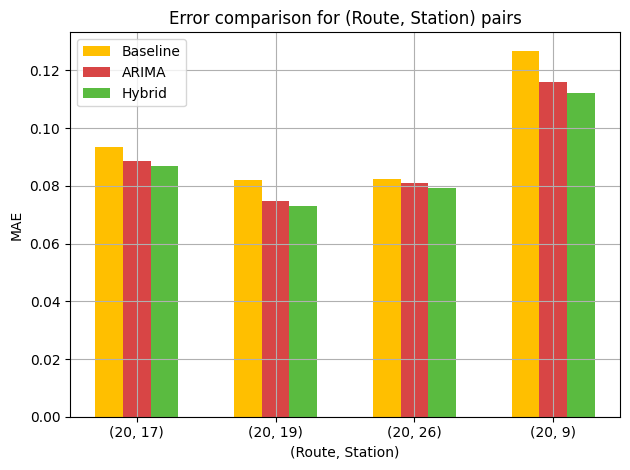

In [16]:
ARIMA_CatBoost_Errors.error_function()

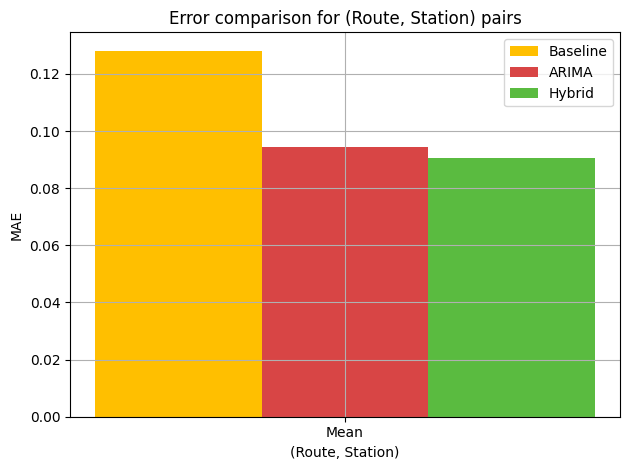

,Error_baseline1,Error_ARIMA1,Error_full1,Error_baseline2,Error_ARIMA2,Error_full2,Error_baseline3,Error_ARIMA3,Error_full3,Error_baseline4,Error_ARIMA4,Error_full4,route_station
0,0.12814,0.094304,0.090708,0.128163,0.101506,0.099079,0.128178,0.103822,0.100298,0.128184,0.106346,0.103849,Mean


In [17]:
ARIMA_XGBoost_Errors.error_function(use_mean=True)

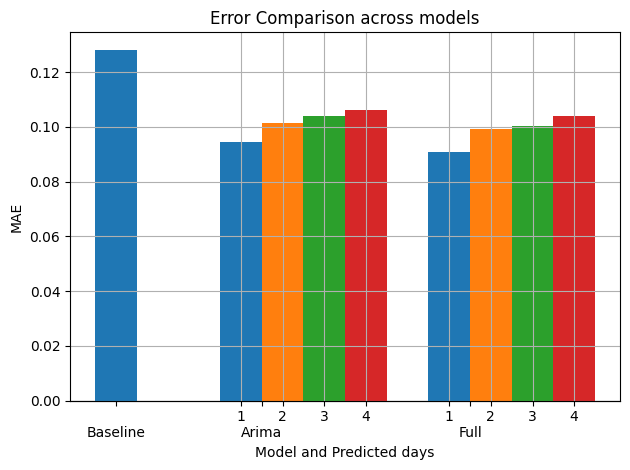

In [18]:
ARIMA_XGBoost_Errors.error_function(use_across_days=True)
# Makes sense: ARIMA is not affected by shifting (it is only in X). The GBDT has difficulties knowing the error arima will make regardless of extra info in X - totally make sense. 

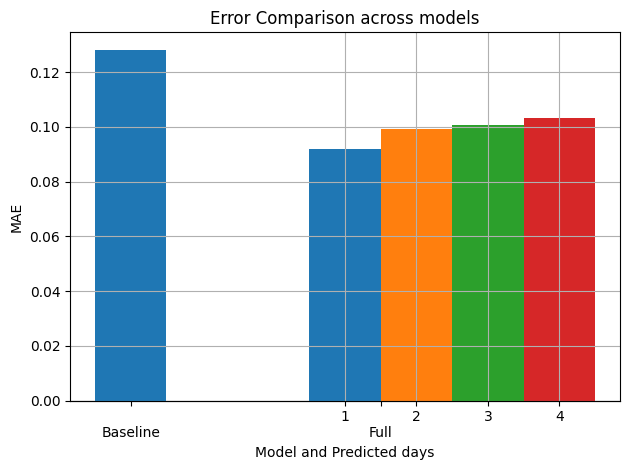

In [19]:
XGBoost_Errors.error_function(use_across_days=True) # More errors here because only XGboost. expected!

# Error visualizations with GBDT models

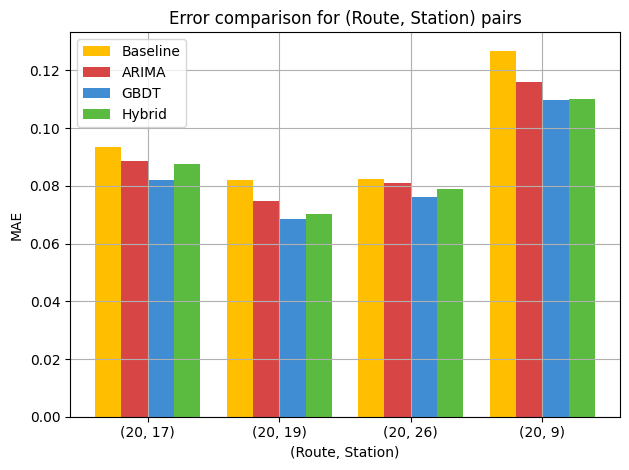

In [20]:
ARIMA_XGBoost_Errors.data_route = pd.concat([ARIMA_XGBoost_Errors.data_route, XGBoost_Errors.data_route.rename(columns={'Error_full1': 'Extra1'})['Extra1']], axis=1)
ARIMA_XGBoost_Errors.error_function(savefig=True)

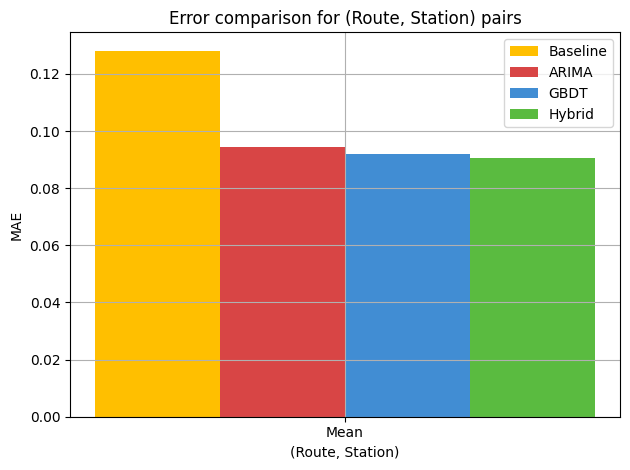

,Error_baseline1,Error_ARIMA1,Error_full1,Error_baseline2,Error_ARIMA2,Error_full2,Error_baseline3,Error_ARIMA3,Error_full3,Error_baseline4,Error_ARIMA4,Error_full4,Extra1,Extra2,Extra3,Extra4,route_station
0,0.12814,0.094304,0.090708,0.128163,0.101506,0.099079,0.128178,0.103822,0.100298,0.128184,0.106346,0.103849,0.092052,0.099134,0.100546,0.103084,Mean


In [21]:
# ARIMA, GDBT and ARIMA together
ARIMA_XGBoost_Errors.data = pd.concat([ARIMA_XGBoost_Errors.data, XGBoost_Errors.data.rename(columns={'Error_full1': 'Extra1', 'Error_full2': 'Extra2', 'Error_full3': 'Extra3', 'Error_full4': 'Extra4'})[['Extra1', 'Extra2', 'Extra3', 'Extra4']]], axis=1)

# Mean plot.
ARIMA_XGBoost_Errors.error_function(use_mean=True, savefig=True)

/var/folders/_6/l3776shn2kq8j4f7hm3qr5bh0000gn/T/ipykernel_1801/1572820281.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  grouped_mean_error[model] = [mean_error['Mean Error'][i] for i in range(len(mean_error['Model'])) if mean_error['Model'][i] == model]


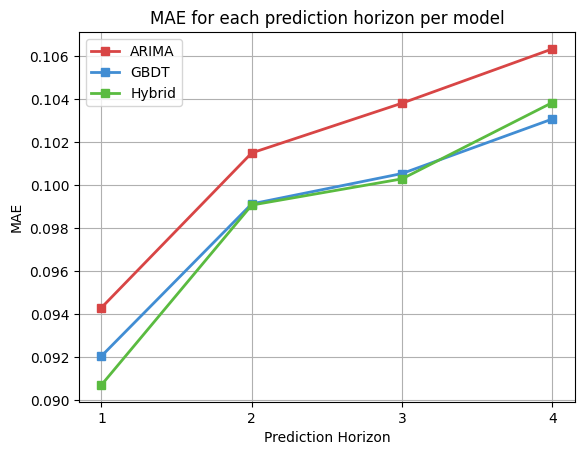

In [22]:
# Line chart
# Preprocessing for line chart of prediction horizon
mean_errors_df1 = ARIMA_XGBoost_Errors.data.iloc[:,1:].mean()
# Concatenate mean errors and add model and prediction horizon columns
prediction_horizon = np.array([1,1,1,2,2,2,3,3,3,4,4,4,1,2,3,4])
models = np.concatenate([np.tile(['Baseline', 'ARIMA', 'Hybrid'], 4), np.tile(['GBDT'], 4)])

# Create DataFrame
mean_error = pd.DataFrame({'Mean Error': mean_errors_df1, 'Prediction Horizon': prediction_horizon, 'Model': models})
mean_error

# Group mean_error by model
grouped_mean_error = {}
for model in set(mean_error[mean_error['Model'] != 'Baseline']['Model']):
    grouped_mean_error[model] = [mean_error['Mean Error'][i] for i in range(len(mean_error['Model'])) if mean_error['Model'][i] == model]


colors = {
    'ARIMA': '#D84545',
    'GBDT': '#418DD3',
    'Hybrid': '#5ABB40'
}

# Plot mean_error
for model, errors in grouped_mean_error.items():
    plt.plot(np.arange(1,5,1), errors, label=model, color=colors[model], linewidth=2, marker='s')
plt.xticks(range(1, 5))
plt.xlabel('Prediction Horizon')
plt.ylabel('MAE')
plt.title('MAE for each prediction horizon per model')
plt.legend()
plt.grid()
plt.savefig("Images/Error_plot_prediction_horizon.pdf")
plt.show()

In [23]:
colors = {
    'ARIMA': '#D84545',
    'XGBoost': '#008CFF',
    'Catboost': '#9157A8',
    'ARIMA_XGBoost': '#2DB43F',
    'ARIMA_Catboost': '#F0912F',
    'Cleaned': '#D84545',
    'Cleaned_lagged': '#008CFF',
    'Cleaned_simple': '#9157A8',
    'Cleaned_simple_lagged': '#2DB43F',
}

dataset_names = {
    'Cleaned': 'Orginal',
    'Cleaned_lagged': 'Original_lagged',
    'Cleaned_simple': 'Simple',
    'Cleaned_simple_lagged': 'Simple_lagged',
}


def plot_columns(data_classes, column, column_arima=None, across_dataset=False):
    datasets = data_classes

    plt.figure(figsize=(10,7))
    bar_width = 0.15
    arima_found=False
    plt.bar([bar_width], (pd.DataFrame(datasets[0].data.mean(axis=0, numeric_only=True)).T.assign(route_station='Mean'))['Error_baseline1'], bar_width, label='Baseline', color="#FFBF00")
    counter = 0
    for i, (dataset) in enumerate(datasets):
        dataset_df = (pd.DataFrame(dataset.data.mean(axis=0, numeric_only=True)).T.assign(route_station='Mean')).sort_values(by='route_station')

        if column_arima in dataset_df.columns and not arima_found:
            plt.bar([(counter+2) * bar_width], dataset_df[column_arima].values, bar_width, label='ARIMA', color='#D84545')
            counter += 1
            arima_found=True
        if across_dataset:
            plt.bar([(counter+2) * bar_width], dataset_df[column].values, bar_width, label=dataset_names[dataset.dataset_name], color=colors[dataset.dataset_name])
        else:
            plt.bar([(counter+2) * bar_width], dataset_df[column].values, bar_width, label=dataset.model_name, color=colors[dataset.model_name])
        counter += 1
        
        #plt.xticks([counter * bar_width-bar_width], dataset_df['route_station'])
    plt.xlabel("Model")
    plt.ylabel("MAE")
    plt.xticks([])
    plt.legend()
    #plt.title(f'Error full on {dataset.dataset_name} data')
    plt.title(f'Error across specific models')
    plt.grid()
    plt.savefig("Images/Error_plot_across_specific_models.pdf", bbox_inches='tight')
    plt.show()


In [24]:
XGBoost_Errors.data.iloc[:,1:].mean(axis=0) # 0.092052
#CatBoost_Errors.data.iloc[:,1:].mean(axis=0) #0.091797

Error_baseline1     0.12814
Error_ARIMA1            NaN
Error_full1        0.092052
Error_baseline2    0.128163
Error_ARIMA2            NaN
Error_full2        0.099134
Error_baseline3    0.128178
Error_ARIMA3            NaN
Error_full3        0.100546
Error_baseline4    0.128184
Error_ARIMA4            NaN
Error_full4        0.103084
dtype: object

In [25]:
np.mean(ARIMA_CatBoost_Errors.data['Error_full1'])

0.09004159426392278

In [26]:
np.mean(ARIMA_XGBoost_Errors.data['Error_full1'])

0.09070820411548865

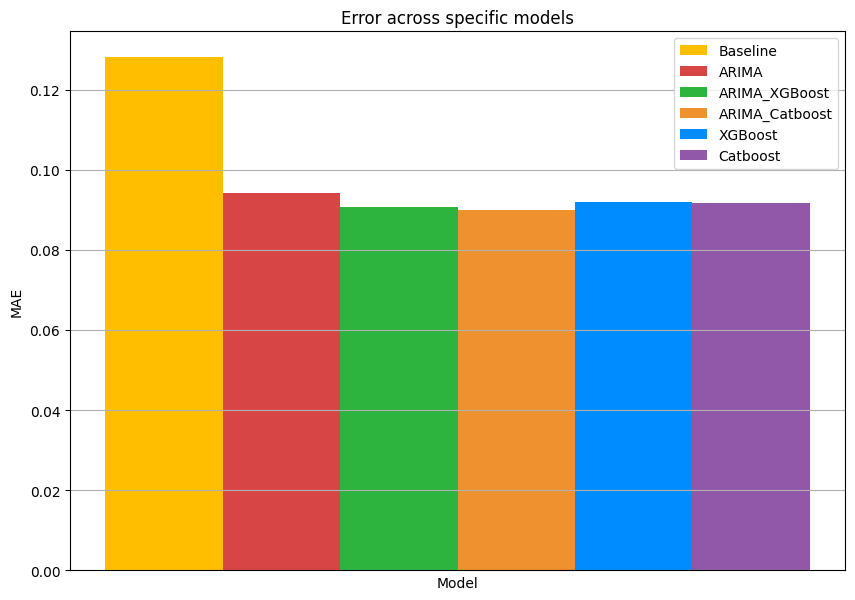

In [27]:
plot_columns([ARIMA_XGBoost_Errors, ARIMA_CatBoost_Errors, XGBoost_Errors, CatBoost_Errors], 'Error_full1', column_arima='Error_ARIMA1')

In [28]:
XGBoost_Errors_Cleaned = Errors('Cleaned', 'XGBoost', 20)
XGBoost_Errors_Cleaned_lagged = Errors('Cleaned_lagged', 'XGBoost', 20)
XGBoost_Errors_Cleaned_simple = Errors('Cleaned_simple', 'XGBoost', 20)
XGBoost_Errors_Cleaned_simple_lagged = Errors('Cleaned_simple_lagged', 'XGBoost', 20)

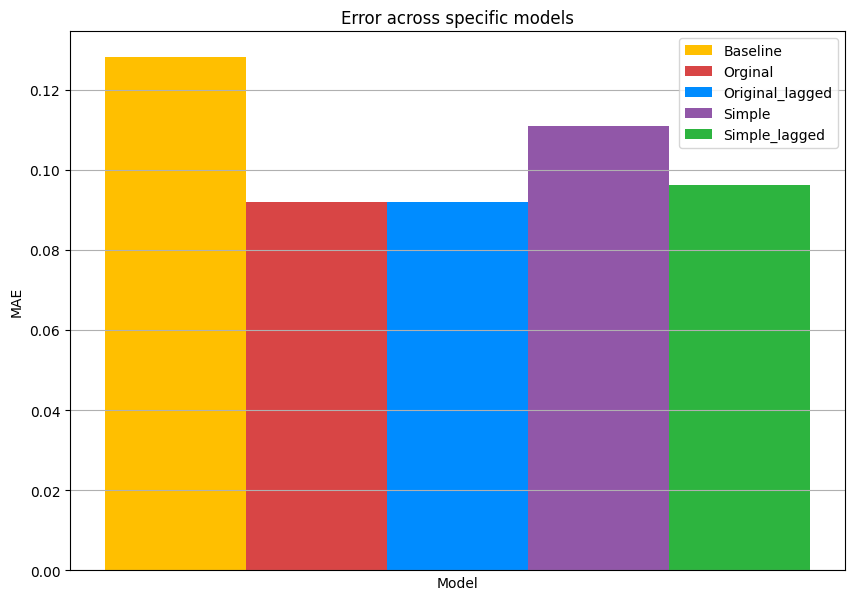

In [29]:
# Across datasets. Pænere potentielt!
plot_columns([XGBoost_Errors_Cleaned, XGBoost_Errors_Cleaned_lagged, XGBoost_Errors_Cleaned_simple, XGBoost_Errors_Cleaned_simple_lagged], 'Error_full1', across_dataset=True)

In [30]:
from matplotlib.ticker import MaxNLocator
import ast

class CV_score(Results):
    def __init__(self, dataset_name, model_names, specific_train_route=None, x=4):
        super().__init__('CV_score', dataset_name, model_names, specific_train_route, x)

    def CV_score_histplot(self, i=1, use_extracted=True):
        data = self.data
        if use_extracted: data = self.data_route
        for _, row in data.iterrows():
            route_station = ast.literal_eval(row['route_station'])
            cv_scores_full = row[f'CV_score_full{i}']
            cv_scores_baseline = row[f'CV_score_baseline{i}']
            cv_scores_arima = cv_scores_arima=row.get(f'CV_score_ARIMA{i}', pd.DataFrame())
            max_score = max(max(cv_scores_baseline), max(cv_scores_full))
            min_score = min(min(cv_scores_baseline), min(cv_scores_full))
            
            arima_check = not cv_scores_arima.empty

            if arima_check:
                max_score = max(max_score, max(cv_scores_arima))
                min_score = min(min_score, min(cv_scores_arima))
            
            num_bins = 15
            bins = np.linspace(min_score, max_score, num_bins)
            
            plt.hist(cv_scores_full, edgecolor="black", bins=bins, alpha=0.4, label='Hybrid', color='#5ABB40')

            
            if arima_check:
                plt.hist(cv_scores_arima, edgecolor="black", bins=bins, alpha=0.4, label='ARIMA', color="#D84545")
            
            plt.hist(cv_scores_baseline, edgecolor="black", bins=bins, alpha=0.4, label='Baseline', color="#FFBF00")
            
            
            plt.title(f'Cross Validation Error for route {route_station[0]} and station {route_station[1]}')
            plt.xlabel('MAE')
            plt.ylabel('Occurrences')
            plt.legend(loc='upper right')
            plt.grid()
            plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True)) # only integer ticks in y-axis
            plt.savefig(f"Images/CV_score_histogram{route_station}.pdf", bbox_inches='tight')
            plt.show()
        
    def CV_score_lineplot(self, i=1, use_extracted=True, initial_start=30):
            data = self.data
            if use_extracted: data = self.data_route
            for j, row in data.iterrows():
                route_station = ast.literal_eval(row['route_station'])
                cv_scores_full = row[f'CV_score_full{i}']
                cv_scores_baseline = row[f'CV_score_baseline{i}']
                cv_scores_arima = cv_scores_arima=row.get(f'CV_score_ARIMA{i}', pd.DataFrame())
                plt.plot(cv_scores_baseline[-initial_start:], label='Baseline', color="#e6ac00", marker='.')
                
                if not cv_scores_arima.empty:
                    plt.plot(cv_scores_arima[-initial_start:], label='ARIMA', color="#D84545", marker='.')

                plt.plot(cv_scores_full[-initial_start:], label='Hybrid', color="#5ABB40", marker='.')
                
                plt.title(f'Cross Validation Error for route {route_station[0]} and station {route_station[1]}')
                plt.xlabel('Data points')
                plt.ylabel('MAE')
                plt.legend(loc='upper right')
                plt.grid()
                plt.savefig(f"Images/CV_score_lineplot{route_station}.pdf", bbox_inches='tight')
                plt.show()
    def CV_score_function(self, use_hist=False, use_line=False, use_extracted=True, initial_start=30):
        if use_hist:
            self.CV_score_histplot(use_extracted = use_extracted)
        if use_line:
            self.CV_score_lineplot(use_extracted=use_extracted, initial_start=initial_start)
    

    def latex_table(self, result_matrix, alpha=0.05):
        # Prepare LaTeX table
        latex_table = "\\begin{table}[ht]\n\\centering\n\\begin{tabular}{|" + "c|" * (len(result_matrix.columns) + 1) + "}\n\\hline\n"
        
        # Header row
        latex_table += " & " + " & ".join(result_matrix.columns) + " \\\\\n\\hline\n"
        
        # Data rows
        for i, row_name in enumerate(result_matrix.index):
            latex_table += row_name
            for j, col_name in enumerate(result_matrix.columns):
                if i == j:
                    # Diagonal cell
                    latex_table += " & \\cellcolor[HTML]{cacaca} --"
                else:
                    p_value = float(result_matrix.loc[row_name, col_name])
                    if p_value < alpha:
                        color = "cellcolor[HTML]{e2ffca}"  # Light green
                    else:
                        color = "cellcolor[HTML]{ffbdbd}"  # Light red
                    latex_table += f" & \\{color} {'%.0e' % p_value}"
            latex_table += " \\\\\n\\hline\n"
        
        latex_table += "\\end{tabular}\n\\caption{P-values from Wilcoxon signed-rank tests.}\n\\label{table:results}\n\\end{table}"
        
        print(latex_table)

    def wilcoxon_test(self, specific_model='', i=1, alpha=0.05, name=''):
        model_columns = [col.split('_')[-1] for col in self.data.columns if col.endswith(str(i))]
        if specific_model:
            print(f'Specific model Comparison: {specific_model}')
            model_columns = ['{}{}'.format(specific_model, j) for j in range(1,5)]


        comparisons = [(model_columns[j], model_columns[k]) for j in range(len(model_columns)) for k in range(j + 1, len(model_columns))]

        result_matrix = pd.DataFrame(columns=model_columns, index=model_columns)

        for (model_name1, model_name2) in comparisons:
            CV_score1 = pd.concat(self.data[f'CV_score_{model_name1}'].tolist())
            CV_score2 = pd.concat(self.data[f'CV_score_{model_name2}'].tolist())
            differences = np.array(CV_score1 - CV_score2)
            
            rounded_differences = np.round(differences, decimals=5)
            # Perform Wilcoxon signed-rank tests
            statistic, p_value = wilcoxon(rounded_differences)
            print(p_value)
            #if p_value < alpha:
            #    result_matrix.loc[model_name1, model_name2] = p_value
            #    result_matrix.loc[model_name2, model_name1] = p_value
            result_matrix.loc[model_name1, model_name2] = p_value
            result_matrix.loc[model_name2, model_name1] = p_value

        for model_name in model_columns:
            result_matrix = result_matrix.rename(index={model_name: model_name[0].upper() + ',' + model_name[-1]}, 
                                                 columns={model_name: model_name[0].upper() + ',' + model_name[-1]})
                                                
        result_matrix = result_matrix.applymap(lambda x: '%.1e' % x)
        self.latex_table(result_matrix, alpha=alpha)
        #result_matrix.to_csv(f'Results/Wilcoxon{name}.csv', float_format='%.2e')
        return result_matrix

In [31]:
XGBoost_CV_scores = CV_score('Cleaned', 'XGBoost', 20)
ARIMA_XGBoost_CV_scores = CV_score('Cleaned', 'ARIMA_XGBoost', 20)

ARIMA_XGBoost_CV_scores.data

,route_station,CV_score_baseline1,CV_score_ARIMA1,CV_score_full1,CV_score_baseline2,CV_score_ARIMA2,CV_score_full2,CV_score_baseline3,CV_score_ARIMA3,CV_score_full3,CV_score_baseline4,CV_score_ARIMA4,CV_score_full4
0,"(27, 17)",0 0.110068 1 0.099001 2 0.10794...,0 0.132764 1 0.111357 2 0.11796...,0 0.068558 1 0.066621 2 0.09788...,0 0.110375 1 0.099305 2 0.10823...,0 0.205994 1 0.165247 2 0.16412...,0 0.202378 1 0.067158 2 0.14998...,0 0.110414 1 0.099409 2 0.10833...,0 0.228722 1 0.209155 2 0.19360...,0 0.232823 1 0.181212 2 0.19648...,0 0.110639 1 0.099629 2 0.10862...,0 0.243072 1 0.220715 2 0.22112...,0 0.240040 1 0.196705 2 0.20512...
1,"(5, 12)",0 0.080081 1 0.027044 2 0.21696...,0 0.104576 1 0.048901 2 0.19144...,0 0.090303 1 0.010433 2 0.18103...,0 0.080048 1 0.026999 2 0.21703...,0 0.140390 1 0.073920 2 0.17946...,0 0.133080 1 0.055530 2 0.19718...,0 0.079956 1 0.026943 2 0.21710...,0 0.149626 1 0.087638 2 0.16978...,0 0.190852 1 0.066912 2 0.17656...,0 0.079999 1 0.027037 2 0.21697...,0 0.146812 1 0.096621 2 0.15638...,0 0.140434 1 0.085572 2 0.17519...
2,"(25, 22)",0 0.284738 1 0.126594 2 0.31353...,0 0.007635 1 0.214139 2 0.04427...,0 0.083220 1 0.221080 2 0.05600...,0 0.284802 1 0.126684 2 0.31354...,0 0.146566 1 0.238630 2 0.03919...,0 0.212384 1 0.142097 2 0.05367...,0 0.285022 1 0.126713 2 0.31359...,0 0.111490 1 0.238539 2 0.07289...,0 0.147909 1 0.282986 2 0.10641...,0 0.285266 1 0.126977 2 0.31366...,0 0.095832 1 0.260617 2 0.11146...,0 0.153046 1 0.237545 2 0.18331...
3,"(16, 20)",0 0.116781 1 0.088728 2 0.12268...,0 0.065968 1 0.042113 2 0.07363...,0 0.071534 1 0.009651 2 0.03252...,0 0.116949 1 0.088888 2 0.12283...,0 0.126640 1 0.072019 2 0.10659...,0 0.104616 1 0.024407 2 0.02767...,0 0.117092 1 0.089071 2 0.12301...,0 0.124938 1 0.127470 2 0.11152...,0 0.083684 1 0.157376 2 0.06222...,0 0.117264 1 0.089172 2 0.12315...,0 0.181598 1 0.107792 2 0.15875...,0 0.188423 1 0.069687 2 0.17705...
4,"(4, 39)",0 0.068330 1 0.068299 2 0.16273...,0 0.082622 1 0.106829 2 0.13558...,0 0.103171 1 0.041394 2 0.20094...,0 0.068424 1 0.068393 2 0.16263...,0 0.135649 1 0.132064 2 0.11442...,0 0.113198 1 0.093260 2 0.14698...,0 0.068446 1 0.068486 2 0.16254...,0 0.132624 1 0.144307 2 0.09501...,0 0.149353 1 0.108052 2 0.15125...,0 0.068603 1 0.068572 2 0.16238...,0 0.139107 1 0.139348 2 0.08123...,0 0.063530 1 0.120743 2 0.12042...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
64,"(2, 2)",0 0.020426 1 0.080417 2 0.03138...,0 0.042049 1 0.108350 2 0.02379...,0 0.054000 1 0.098369 2 0.01315...,0 0.020490 1 0.080473 2 0.03146...,0 0.090740 1 0.131456 2 0.08326...,0 0.092586 1 0.102388 2 0.03722...,0 0.020455 1 0.080459 2 0.03144...,0 0.107415 1 0.160668 2 0.09708...,0 0.118339 1 0.156305 2 0.08207...,0 0.020469 1 0.080480 2 0.03148...,0 0.121297 1 0.171563 2 0.11649...,0 0.109561 1 0.151386 2 0.09232...
65,"(19, 17)",0 0.045486 1 0.118465 2 0.02658...,0 0.104225 1 0.091968 2 0.07265...,0 0.109142 1 0.053125 2 0.07489...,0 0.045428 1 0.118483 2 0.02653...,0 0.026290 1 0.140115 2 0.03012...,0 0.004454 1 0.108984 2 0.01883...,0 0.045475 1 0.118415 2 0.02653...,0 0.058836 1 0.099299 2 0.00484...,0 0.062976 1 0.087940 2 0.03909...,0 0.045585 1 0.118569 2 0.02649...,0 0.071622 1 0.131714 2 0.04581...,0 0.072486 1 0.138784 2 0.07459...
66,"(11, 16)",0 0.046111 1 0.054090 2 0.11006...,0 0.018465 1 0.029514 2 0.08030...,0 0.026964 1 0.013778 2 0.06166...,0 0.046113 1 0.054084 2 0.11006...,0 0.047671 1 0.036168 2 0.08831...,0 0.059332 1 0.033336 2 0.04572...,0 0.046103 1 0.054092 2 0.11006...,0 0.083454 1 0.057884 2 0.09994...,0 0.064839 1 0.047760 2 0.10674...,0 0.045944 1 0.054018 2 0.11000...,0 0.029144 1 0.081748 2 0.11257...,0 0.021495 1 0.076106 2 0.08970...
67,"(4, 43)",0 0.092812 1 0.092769 2 0.01572...,0 0.115583 1 0.071972 2 0.00622...,0 0.099336 1 0.036098 2 0.04908...,0 0.092792 1 0.092800 2 0.01575...,0 0.126400 1 0.118583 2 0.02273...,0 0.101051 1 0.090794 2 0.01401...,0 0.092856 1 0.092884 2 0.01589...,0 0.1137

In [32]:
# ARIMA, GDBT and ARIMA together
ARIMA_XGBoost_CV_scores.data = pd.concat([ARIMA_XGBoost_CV_scores.data, XGBoost_CV_scores.data.rename(columns={'CV_score_full1': 'CV_score_GBDT1', 'CV_score_full2': 'CV_score_GBDT2', 'CV_score_full3': 'CV_score_GBDT3', 'CV_score_full4': 'CV_score_GBDT4'})[['CV_score_GBDT1', 'CV_score_GBDT2', 'CV_score_GBDT3', 'CV_score_GBDT4']]], axis=1)
desired_order = ['CV_score_baseline1', 'CV_score_baseline2', 'CV_score_baseline3', 'CV_score_baseline4',
                 'CV_score_ARIMA1', 'CV_score_ARIMA2', 'CV_score_ARIMA3', 'CV_score_ARIMA4',
                 'CV_score_GBDT1', 'CV_score_GBDT2', 'CV_score_GBDT3', 'CV_score_GBDT4',
                 'CV_score_full1', 'CV_score_full2', 'CV_score_full3', 'CV_score_full4']

ARIMA_XGBoost_CV_scores.data = ARIMA_XGBoost_CV_scores.data[desired_order]


In [33]:
ARIMA_XGBoost_CV_scores.wilcoxon_test(i=4)

6.723063861910751e-27
3.703896584413781e-128
9.539524616865636e-58
1.891730386372043e-30
4.0282773611640553e-35
6.22710631437344e-09
\begin{table}[ht]
\centering
\begin{tabular}{|c|c|c|c|c|}
\hline
 & B,4 & A,4 & G,4 & F,4 \\
\hline
B,4 & \cellcolor[HTML]{cacaca} -- & \cellcolor[HTML]{e2ffca} 7e-27 & \cellcolor[HTML]{e2ffca} 4e-128 & \cellcolor[HTML]{e2ffca} 9e-58 \\
\hline
A,4 & \cellcolor[HTML]{e2ffca} 7e-27 & \cellcolor[HTML]{cacaca} -- & \cellcolor[HTML]{e2ffca} 2e-30 & \cellcolor[HTML]{e2ffca} 4e-35 \\
\hline
G,4 & \cellcolor[HTML]{e2ffca} 4e-128 & \cellcolor[HTML]{e2ffca} 2e-30 & \cellcolor[HTML]{cacaca} -- & \cellcolor[HTML]{e2ffca} 6e-09 \\
\hline
F,4 & \cellcolor[HTML]{e2ffca} 9e-58 & \cellcolor[HTML]{e2ffca} 4e-35 & \cellcolor[HTML]{e2ffca} 6e-09 & \cellcolor[HTML]{cacaca} -- \\
\hline
\end{tabular}
\caption{P-values from Wilcoxon signed-rank tests.}
\label{table:results}
\end{table}


/var/folders/_6/l3776shn2kq8j4f7hm3qr5bh0000gn/T/ipykernel_1801/465331992.py:132: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  result_matrix = result_matrix.applymap(lambda x: '%.1e' % x)


,"B,4","A,4","G,4","F,4"
"B,4",nan,6.7e-27,3.7e-128,9.5e-58
"A,4",6.7e-27,nan,1.9e-30,4.0e-35
"G,4",3.7e-128,1.9e-30,nan,6.2e-09
"F,4",9.5e-58,4.0e-35,6.2e-09,nan


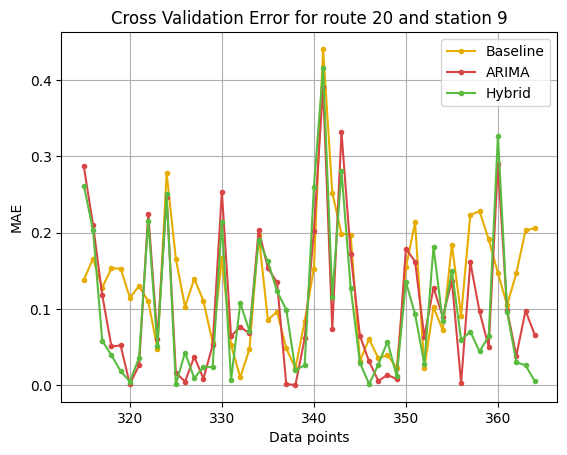

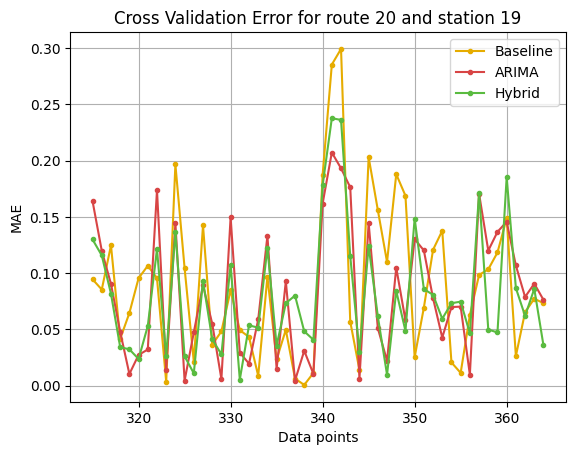

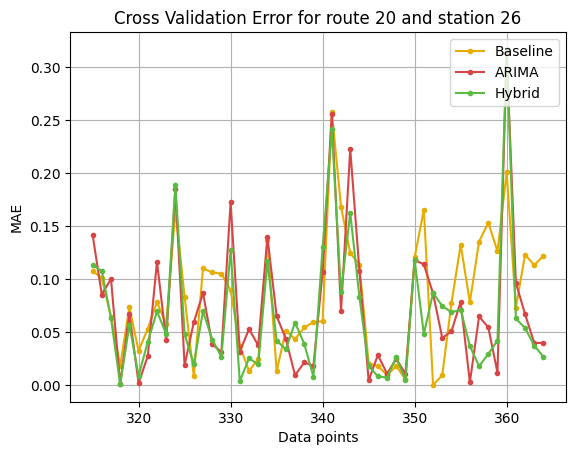

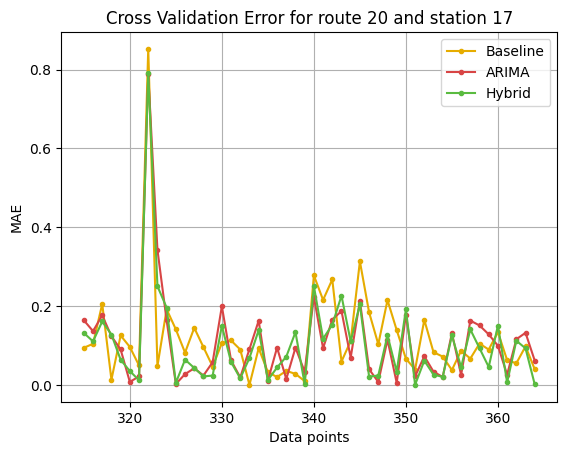

In [34]:
ARIMA_XGBoost_CV_scores.CV_score_function(use_line=True, initial_start=50)

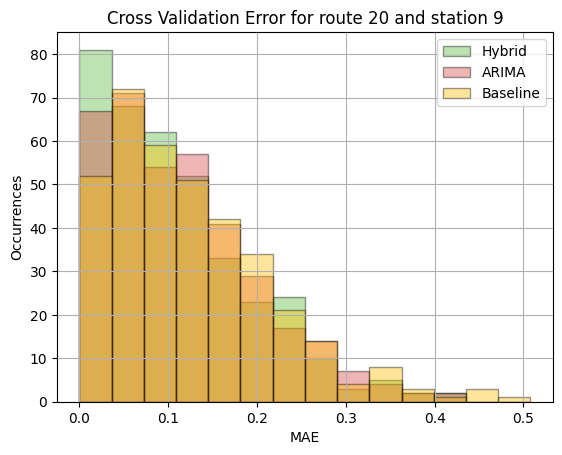

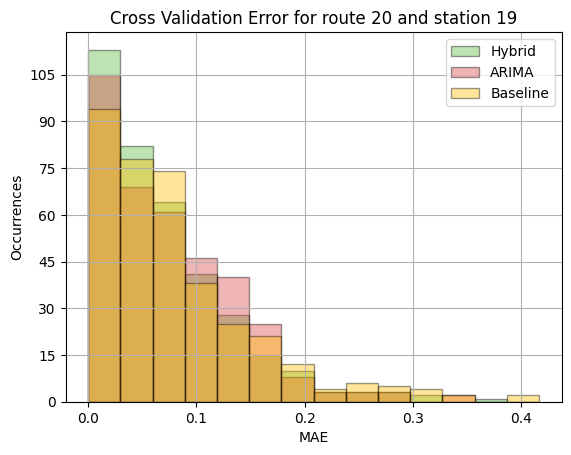

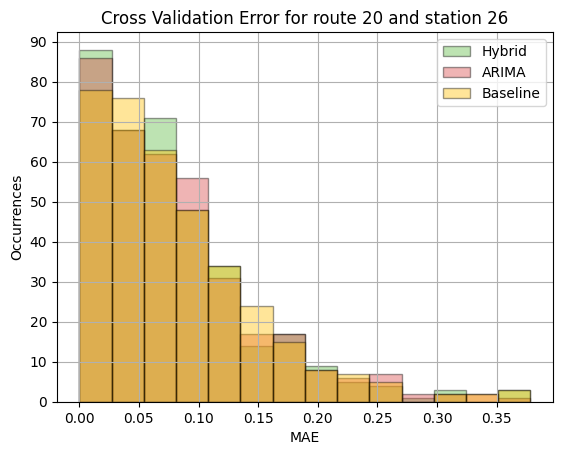

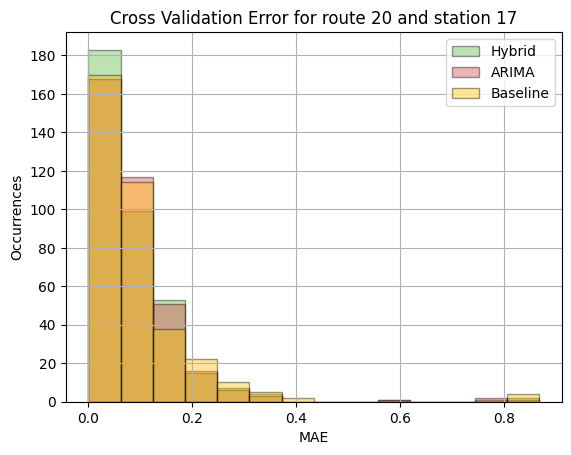

In [35]:
ARIMA_XGBoost_CV_scores.CV_score_function(use_hist=True)

In [36]:
class Predictions(Results):
    def __init__(self, dataset_name, model_names, specific_train_route=None, x=4):
        super().__init__('Predictions', dataset_name, model_names, specific_train_route, x)

    def prediction_plot(self, i, start, end, arima=False, use_extracted=True, use_gbdt=False):
        data = self.data
        if use_extracted: data = self.data_route
        for row_no, row in data.iterrows():
            y_test = row[f'y_true{i}']
            # Extract corresponding predictions from predictions DataFrame
            predictions_full = row[f'Predictions_full{i}']
            # Dates: 
            x_dates = np.arange(start-end)
            route_station = row['route_station']
            plt.plot(x_dates, y_test[-start:-end], color='#888888', label='Test Data', linewidth=1)
            if arima:
                predictions_arima = row.get(f'Predictions_ARIMA{i}', [None])
                plt.plot(x_dates, predictions_arima[-start:-end], color='#D84545', marker='.', label='ARIMA', linewidth=2)
            if use_gbdt:
                predictions_gbdt = row.get(f'Predictions_GBDT{i}', [None])
                plt.plot(x_dates, predictions_gbdt[-start:-end], color='#418DD3', marker='.', label='GBDT', linewidth=2)

            plt.plot(x_dates, predictions_full[-start:-end], color='#5ABB40', marker='.', label='Hybrid', linewidth=2)
            plt.title(f'Route/station {route_station}: Predictions & True Value')
            plt.xlabel('Observations')
            plt.ylabel('Train punctuality')
            plt.yticks(np.arange(0,1.1,0.1))
            plt.xticks(x_dates[-start::5], rotation=45)
            plt.legend(loc='lower right')
            plt.grid()
            if row['route_station'] == '(20, 9)':
                plt.savefig('Images/Predictions_20_9_i=1.pdf')
            plt.show()
    def prediction_function(self, i, start, end, arima, use_extracted, use_gbdt=False):
        self.prediction_plot(i, start, end, arima, use_extracted, use_gbdt=use_gbdt)

In [37]:
ARIMA_XGBoost_Predictions = Predictions('Cleaned', 'ARIMA_XGBoost', 20)
XGBoost_Predictions = Predictions('Cleaned', 'XGBoost', 20)
#ARIMA_XGBoost_Predictions.data

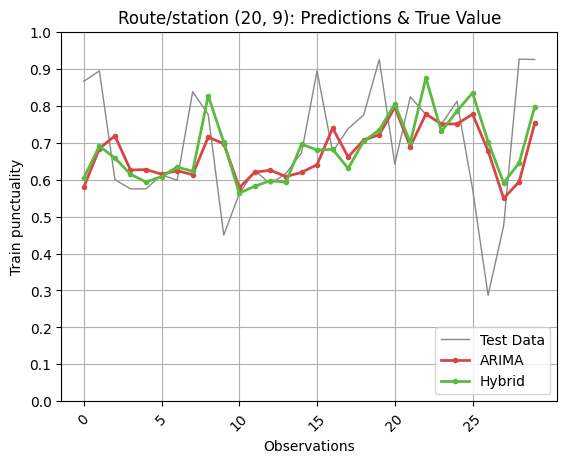

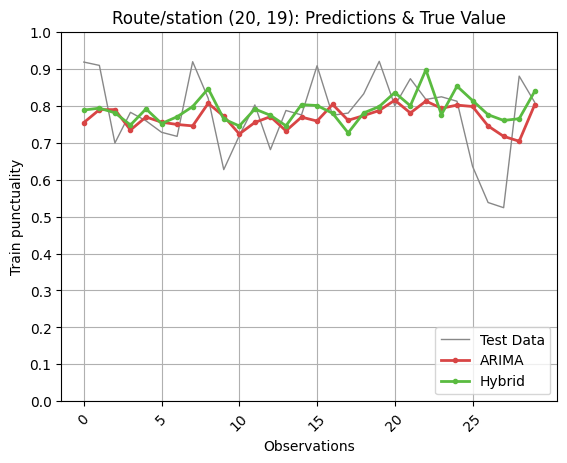

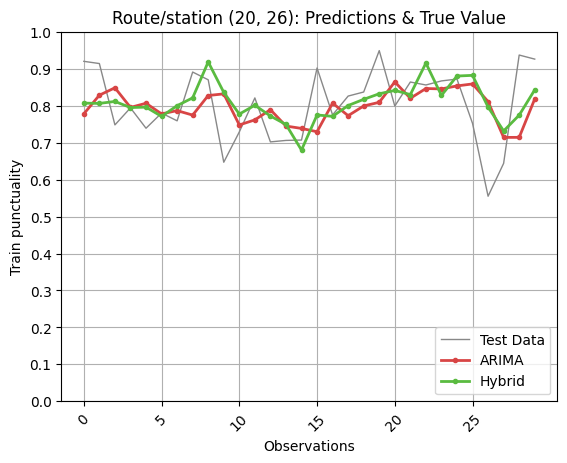

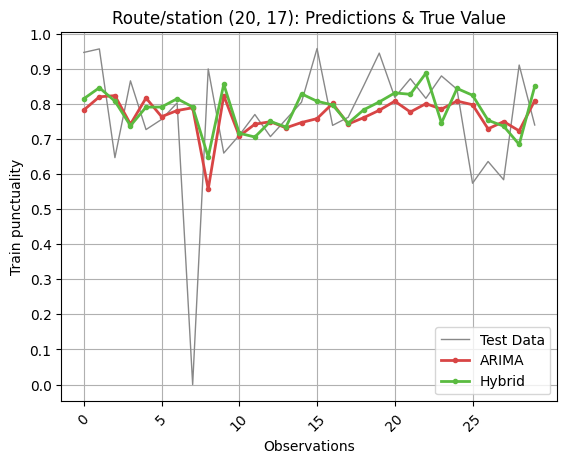

In [38]:
ARIMA_XGBoost_Predictions.prediction_function(i=1, start=50, end=20, arima=True, use_extracted=True)

In [39]:
# ARIMA, GDBT and ARIMA together
ARIMA_XGBoost_Predictions.data_route = pd.concat([ARIMA_XGBoost_Predictions.data_route,XGBoost_Predictions.data_route.rename(columns={'Predictions_full1': 'Predictions_GBDT1', 'Predictions_full2': 'Predictions_GBDT2', 'Predictions_full3': 'Predictions_GBDT3', 'Predictions_full4': 'Predictions_GBDT4'})[['Predictions_GBDT1', 'Predictions_GBDT2', 'Predictions_GBDT3', 'Predictions_GBDT4']]], axis=1)

In [40]:
# ARIMA, GDBT and ARIMA together
ARIMA_XGBoost_Predictions.data_route.columns

Index(['route_station', 'Predictions_baseline1', 'Predictions_ARIMA1',
       'Predictions_full1', 'y_true1', 'Predictions_baseline2',
       'Predictions_ARIMA2', 'Predictions_full2', 'y_true2',
       'Predictions_baseline3', 'Predictions_ARIMA3', 'Predictions_full3',
       'y_true3', 'Predictions_baseline4', 'Predictions_ARIMA4',
       'Predictions_full4', 'y_true4', 'Predictions_GBDT1',
       'Predictions_GBDT2', 'Predictions_GBDT3', 'Predictions_GBDT4'],
      dtype='object')

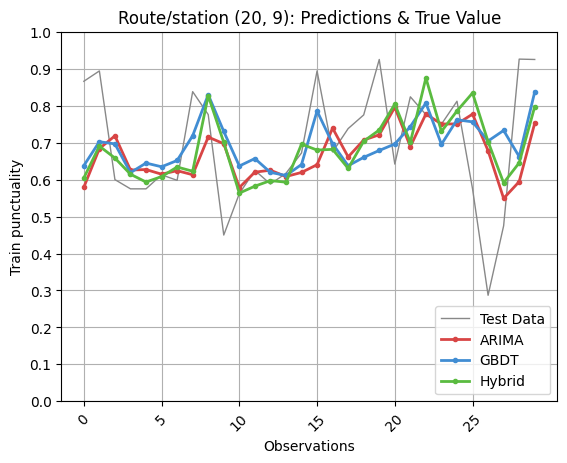

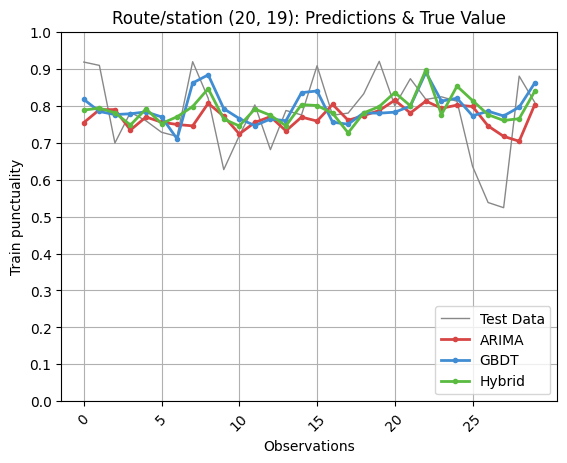

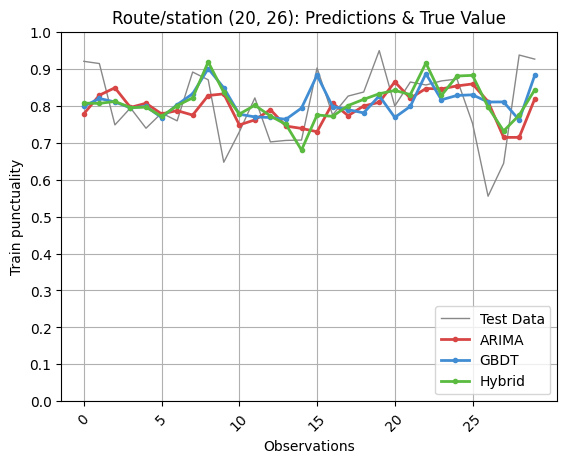

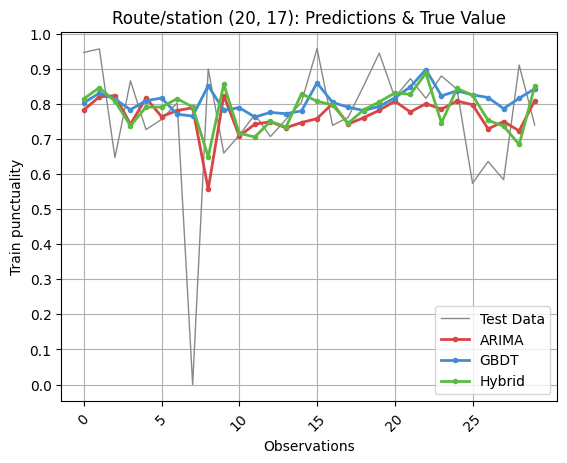

In [41]:
ARIMA_XGBoost_Predictions.prediction_function(i=1, start=50, end=20, arima=True, use_extracted=True, use_gbdt=True)

In [42]:
table = np.zeros((4,4))

for i in range(1,5):
    for j, model in enumerate(['XGBoost', 'Catboost', 'ARIMA_XGBoost', 'ARIMA_Catboost']):
        pred = Predictions('Cleaned', model, 20)
        prediction_series = pred.data[f'Predictions_full{i}']
        prediction_mean_series = prediction_series.apply(lambda x: x.mean())
        prediction_overall_mean = prediction_mean_series.mean()
        table[i-1,j] = prediction_overall_mean

In [43]:
table

array([[0.82684914, 0.815872  , 0.81290353, 0.81772728],
       [0.82686296, 0.8155831 , 0.80861559, 0.81258237],
       [0.82768858, 0.81754968, 0.80991695, 0.81430746],
       [0.82490962, 0.81561348, 0.80753268, 0.81160402]])

In [44]:
# Perspektivering til BaneDanmark.
ARIMA_XGBoost_Predictions = Predictions('Cleaned', 'ARIMA_XGBoost', 20)
prediction_series = ARIMA_XGBoost_Predictions.data['Predictions_baseline1']
true_series = ARIMA_XGBoost_Predictions.data['y_true1']
prediction_mean_series = prediction_series.apply(lambda x: x.mean())
true_mean_series = true_series.apply(lambda x: x.mean())
prediction_overall_mean = prediction_mean_series.mean()
true_overall_mean = true_mean_series.mean()
print(f"True mean: {true_overall_mean}. Prediction mean: {prediction_overall_mean}")

True mean: 0.7974136192177883. Prediction mean: 0.8536946404356042


In [45]:
Catboost_Predictions = Predictions('Cleaned', 'ARIMA_Catboost', 20)
# Perspektivering til BaneDanmark.
prediction_series = Catboost_Predictions.data['Predictions_full1']
true_series = Catboost_Predictions.data['y_true1']
prediction_mean_series = prediction_series.apply(lambda x: x.mean())
true_mean_series = true_series.apply(lambda x: x.mean())
prediction_overall_mean = prediction_mean_series.mean()
true_overall_mean = true_mean_series.mean()
print(f"True mean: {true_overall_mean}. Prediction mean: {prediction_overall_mean}")

True mean: 0.7974136192177884. Prediction mean: 0.8177272751745097


In [51]:
import shap
import textwrap
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.ticker import MultipleLocator, FixedFormatter, FixedLocator



class FeatureImportance(Results):
      def __init__(self, dataset_name, model_names, specific_train_route=None, x=4):
         super().__init__('FI', dataset_name, model_names, specific_train_route, x)
         self.dataset = pd.read_csv(f'Data/{self.dataset_name}_data.csv')

         self.mean_matrix_all = self.mean_matrix_calculation()
         self.mean_matrix_route = self.mean_matrix_calculation(use_extracted=True)
         self.feature_importance_path = f'Results/SHAP_consistency/{dataset_name}/{model_names}/*feature_importances365.csv'
         self.data_consistency = self.data_from_files_consistency()
         if len(self.data_consistency) != 0:
               self.mean_matrix_consistency = self.mean_matrix_calculation_consistency()

      def data_from_files(self, relative_path, measure):
            file_list_results = glob.glob(relative_path)
        
            result_df = pd.DataFrame()

            for file in file_list_results:
                  index_start = len(relative_path.split('*')[0])
                  data_from_file = pd.read_csv(file)
                  file_dict = {}
                  file_dict['route_station'] = file[index_start:].split('_')[0]

                  file_dict['Feature_importances'] = [data_from_file.to_numpy().T]
                  result_df = pd.concat([result_df, pd.DataFrame(file_dict, index=[0])], ignore_index=True)
            return result_df
      
      def data_from_files_consistency(self):
            file_list_results = glob.glob(self.feature_importance_path)

            result_df = pd.DataFrame()

            for file in file_list_results:
                  index_start = len(self.feature_importance_path.split('*')[0])
                  data_from_file = pd.read_csv(file)
                  file_dict = {}
                  file_dict['route_station'] = file[index_start:].split('_')[0] + file[index_start:].split('_')[1][-1]

                  file_dict['Feature_importances'] = [data_from_file.to_numpy().T]
                  result_df = pd.concat([result_df, pd.DataFrame(file_dict, index=[0])], ignore_index=True)
            return result_df

      
      def mean_matrix_calculation(self, use_extracted = False):
            data = self.data
            if use_extracted:
                  data = self.data_route
            mean_matrix = np.zeros(data.iloc[0,1].shape)
            for i in range(0,len(data)):
                  mean_matrix += np.abs(data.iloc[i,1])
            mean_matrix = mean_matrix / (i+1)
            return mean_matrix
      
      def mean_matrix_calculation_consistency(self):
            data = self.data_consistency
            mean_matrix = np.zeros((data.iloc[0,1].shape[0], data.iloc[0,1].shape[1], 6))
            for i in range(0,len(data)):
                  period = int(data.iloc[i,0][-1])
                  mean_matrix[:,:,period] += np.abs(data.iloc[i,1])
            mean_matrix = mean_matrix / (i+1)
            return mean_matrix

      def plot_consistency1(self):
            periods = [f'20{17+i}'for i in range(6)]
            for i in range(self.mean_matrix_consistency.shape[2]):
                  new_mean_matrix=np.abs(self.mean_matrix_consistency[:,:,i]).mean(0)
                  data_used = self.dataset.iloc[:, 2:]
                  feature_importance = pd.DataFrame(list(zip(data_used.columns,new_mean_matrix)),columns=['col_name','feature_importance_vals'])
                  feature_importance.sort_values(by=['feature_importance_vals'],ascending=False,inplace=True)
                  plt.barh(feature_importance.iloc[:10,0].values, feature_importance.iloc[:10,1].values, label=periods[i])
                  plt.xticks(rotation=-45)
                  plt.legend()
                  plt.grid()
                  plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))

                  #self.plot_shap_summary(new_mean_matrix=self.mean_matrix_consistency[:,:,i])
            #plt.show()

      def plot_consistency(self):
            periods = [f'20{17+i}' for i in range(6)]
            top_features = []

            # Extract top 10 features for each period
            for i in range(self.mean_matrix_consistency.shape[2]):
                  new_mean_matrix = np.abs(self.mean_matrix_consistency[:,:,i]).mean(0)
                  data_used = self.dataset.iloc[:, 2:]
                  feature_importance = pd.DataFrame(list(zip(data_used.columns, new_mean_matrix)), columns=['col_name', 'feature_importance_vals'])
                  feature_importance.sort_values(by=['feature_importance_vals'], ascending=False, inplace=True)
                  top_features.append(feature_importance.iloc[:10, 0].values)

            # Create a DataFrame to store the presence of top features across periods
            feature_presence = pd.DataFrame(index=np.unique(np.concatenate(top_features)), columns=periods)
            feature_presence = feature_presence.fillna(0)

            # Update the presence matrix with placement
            for i, features in enumerate(top_features):
                  for rank, feature in enumerate(features):
                        feature_presence.loc[feature, periods[i]] = rank + 1  # Rank starts from 1
            # Create custom colormap with white for 0, dark for 1, and brighter colors for higher ranks
            # Custom colormap
            from matplotlib.colors import LinearSegmentedColormap
            colors = ['#3f7f93', '#f2f2f2']  # Red, Yellow, Green
            positions = [0, 1] 
            cmap_name = 'custom_colormap'
            cmap = LinearSegmentedColormap.from_list(cmap_name, list(zip(positions, colors)))

            #cmap_colors = [(0.7, 1, 0.7)]  # White color for 0
            #for i in range(11, 1, -1):
            #      brightness = 1 - (i / 11)  # Calculate brightness (0 for rank 1, 1 for rank 10)
            #      cmap_colors.append((brightness, brightness, 1))  # Blueish color with varying brightness
            #cmap = LinearSegmentedColormap.from_list('custom_cmap', cmap_colors)

            # Plot heatmap with actual placement
            plt.figure(figsize=(10, 8))
            sns.heatmap(feature_presence, cmap=cmap, annot=True, cbar=True, center=5, fmt= ".0f", mask=(feature_presence == 0))
            plt.title('Top Features Across Time Periods')
            plt.xlabel('Time Period')
            plt.ylabel('Top Features')
            plt.xticks(rotation=45)
            plt.yticks(rotation=0)
            plt.tight_layout()
            plt.savefig('Images/Feature_consistency.png', dpi=150, bbox_inches = 'tight')
            plt.show()


      def plot_shap_summary(self, plot_type='dot', new_mean_matrix=None, new_dataset=None, use_extracted=False, cmap=None):
            #mean_shap_values = np.abs(new_mean_matrix).mean(axis=0)
            data_used1 = self.dataset.iloc[:, 2:]
            data_used2 = new_dataset
            max_display = 10

            shap_values1 = self.mean_matrix_all
            shap_values2 = new_mean_matrix
            # Calculate mean SHAP values for both sets of SHAP values
            mean_shap_values1 = np.abs(shap_values1).mean(axis=0)
            mean_shap_values2 = np.abs(shap_values2).mean(axis=0)

            # Sort features based on mean SHAP values for both sets
            sorted_indices1 = np.argsort(mean_shap_values1)[::-1]
            sorted_indices2 = np.argsort(mean_shap_values2)[::-1]

            # Get top feature names and corresponding SHAP values for both sets
            top_indices1 = sorted_indices1[:max_display]
            top_indices2 = sorted_indices2[:max_display]

            top_feature_names1 = [data_used1.columns[i] for i in top_indices1]
            top_feature_names2 = [data_used2.columns[i] for i in top_indices2]

            top_shap_values1 = mean_shap_values1[top_indices1]
            top_shap_values2 = mean_shap_values2[top_indices2]

            # Plot top features
            plt.figure(figsize=(12, 6))
            # Bar width and offset
            bar_width = 0.35
            offset = bar_width / 2

            all_top_feature_names = np.unique(top_feature_names1 + top_feature_names2)
            #print(all_top_feature_names)
            plt.yticks(np.arange(len(all_top_feature_names)), all_top_feature_names)
            
            # Plot bars for the first set of SHAP values
            plt.barh(np.arange(len(all_top_feature_names)) - offset, [top_shap_values1[top_feature_names1.index(feature)] if feature in top_feature_names1 else 0 for feature in all_top_feature_names], height=bar_width, color='#3f7f93', label='Orginal Dataset')

            # Plot bars for the second set of SHAP values with an offset
            plt.barh(np.arange(len(all_top_feature_names)) + offset, [top_shap_values2[top_feature_names2.index(feature)] if feature in top_feature_names2 else 0 for feature in all_top_feature_names], height=bar_width, color='#c3553a', label='Original_lagged Dataset')

            plt.xlabel('Mean |SHAP Value|')
            plt.ylabel('Feature')
            plt.title('Top {} Features across datasets'.format(max_display))
            plt.gca().invert_yaxis()  # Invert y-axis to display top features at the top
            plt.legend()
            plt.tight_layout()
            plt.grid()
            plt.savefig("Images/Feature_importance.png", dpi=150)
            plt.show()
      """
      def plot_shap_summary(self, plot_type='dot', new_mean_matrix=None, use_extracted = False, cmap=None):
            shap_values = self.mean_matrix_all
            if use_extracted:
                  shap_values = self.mean_matrix_route
            if new_mean_matrix is not None:
                  shap_values = new_mean_matrix

            data_used = self.dataset.iloc[-len(shap_values)-3:-3, 2:] # used only the 365 last datapoints and not the last 3 ones because horizon = 4, columns excluded are date and train punctuality
            shap.summary_plot(shap_values, data_used, show=False, max_display=10, plot_type=plot_type, plot_size=(0.1,16), cmap=cmap, color='#3f7f93') #  feature_names=np.array(feature_names).reshape(211,1)
            shap.summary_plot(shap_values, data_used, show=False, max_display=10, plot_type=plot_type, plot_size=(0.1,16), cmap=cmap, color='#333333')
            plt.gcf().set_size_inches(12, 10)

            ax = plt.gca()
            tick_labels = ax.get_yticklabels()
            # Wrap long tick labels to the next line
            max_chars_per_line = 40  # Define the maximum number of characters per line
            wrapped_tick_labels = []
            for label in tick_labels:
                  text = label.get_text()
                  # Find the nearest underscore within the specified range
                  underscore_index = min(max_chars_per_line, len(text))  # Initialize with max_chars_per_line
                  for i in range(max_chars_per_line - 5, len(text)):
                        if text[i] == '_':
                              underscore_index = i
                              break
                  wrapped_tick_labels.append(textwrap.fill(text, underscore_index+1))

            # Set the wrapped tick labels
            ax.set_yticklabels(wrapped_tick_labels[:len(shap_values)])  # Ensure the number of labels matches the number of shap values


            plt.yticks(fontsize = 12)
            plt.xticks(fontsize=12)
            plt.savefig('Images/Feature_importance.png', dpi=150, bbox_inches = 'tight')
            plt.show()"""

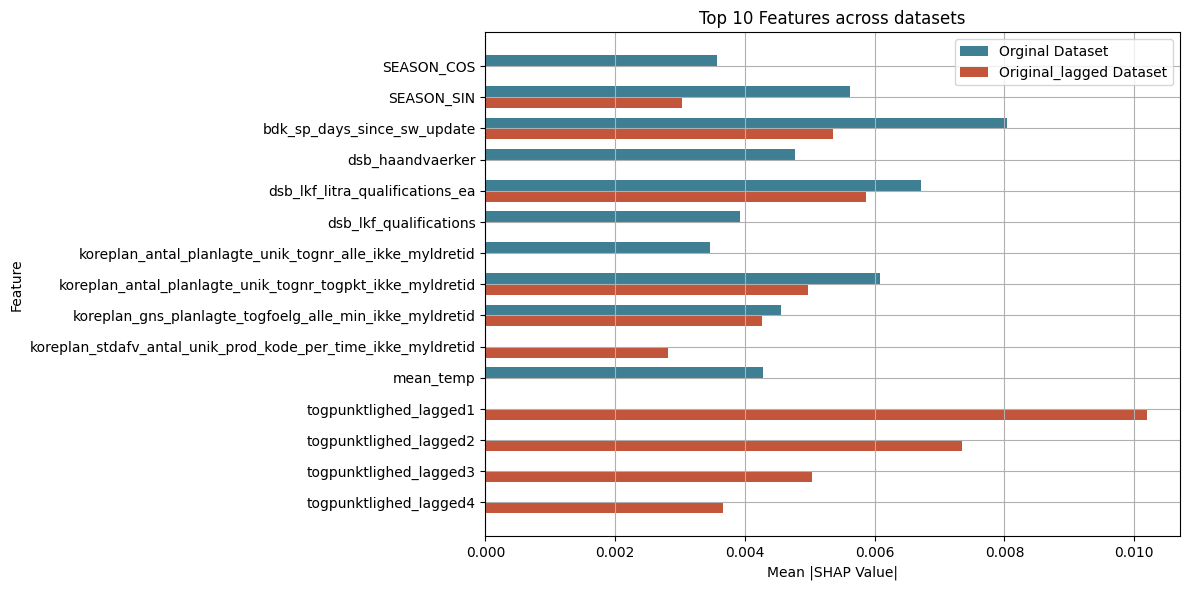

In [52]:
FI_Cleaned_lagged_XGBoost = FeatureImportance('Cleaned_lagged', 'XGBoost', 20)
FI_Cleaned_XGBoost = FeatureImportance('Cleaned', 'XGBoost', 20)
FI_Cleaned_XGBoost.plot_shap_summary(new_mean_matrix=FI_Cleaned_lagged_XGBoost.mean_matrix_all, new_dataset=FI_Cleaned_lagged_XGBoost.dataset.iloc[:, 2:], plot_type='bar')

In [50]:
FI_Cleaned_lagged_XGBoost.mean_matrix_all

array([[0.        , 0.        , 0.00995562, ..., 0.00040824, 0.00043762,
        0.00039299],
       [0.        , 0.        , 0.01024906, ..., 0.00050922, 0.00044586,
        0.00051811],
       [0.        , 0.        , 0.00837345, ..., 0.00173125, 0.00036477,
        0.00050211],
       ...,
       [0.        , 0.        , 0.00733529, ..., 0.00067363, 0.00036852,
        0.00030651],
       [0.        , 0.        , 0.00682419, ..., 0.00069682, 0.00066325,
        0.00042346],
       [0.        , 0.        , 0.00655011, ..., 0.00189239, 0.0003928 ,
        0.00046175]])

/var/folders/_6/l3776shn2kq8j4f7hm3qr5bh0000gn/T/ipykernel_1801/1169408799.py:101: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  feature_presence = feature_presence.fillna(0)


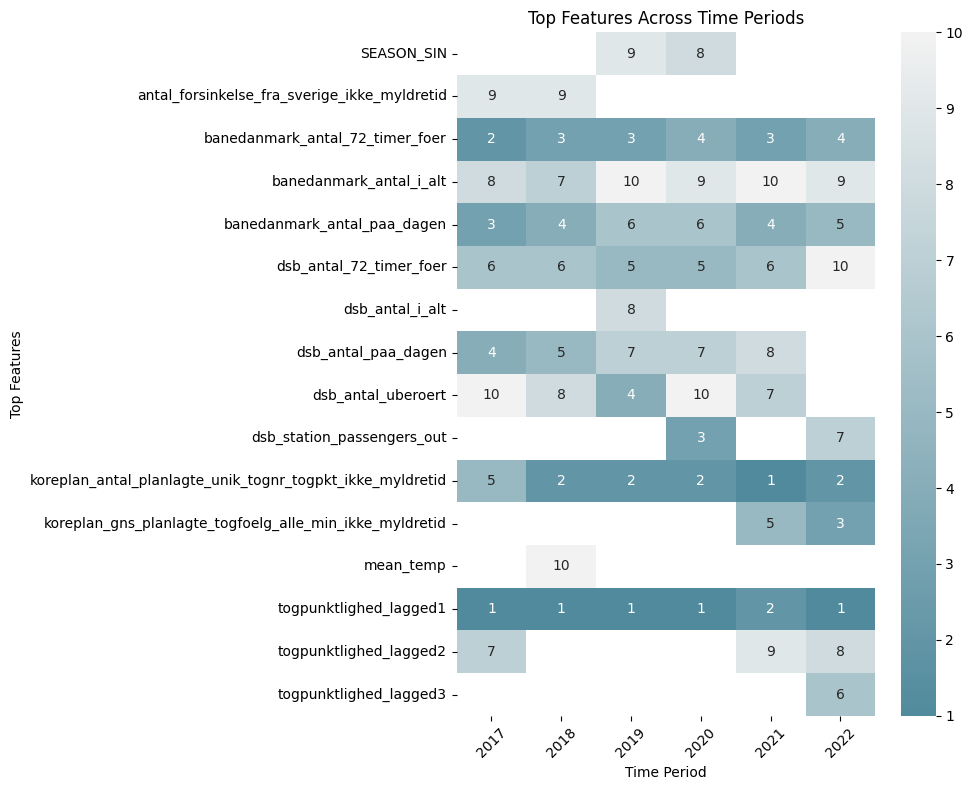

In [53]:
FI_Cleaned_lagged_XGBoost.plot_consistency()

In [68]:
def visualize_strækning(data_start, straekning, station, save=False, ending=''):
    strækning_data = data_start[(data_start['visualiseringskode'] == straekning) & (data_start['station'] == station)]
    data_strækning_daily = strækning_data
    print(strækning_data.shape[0])
    plt.plot(data_strækning_daily['dato'], data_strækning_daily['togpunktlighed'])
    plt.grid()
    plt.title(f'Route {straekning}')
    if save:
        plt.tight_layout()
        plt.savefig(f'Results/Data_Cleaning_DeleteZeros{straekning}{ending}')
    plt.show()

In [69]:
data = pd.read_csv('Data/Cleaned_data.csv')
data['dato'] = pd.to_datetime(data['dato'])

2557


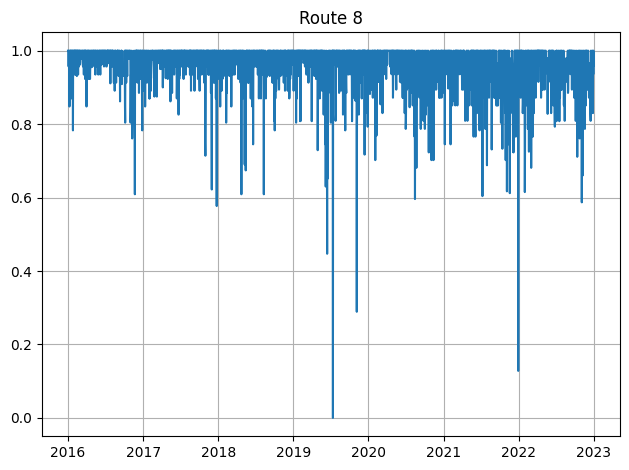

In [78]:
visualize_strækning(data, 8, 44, save=True, ending='8')